## Classifying the type of Twitter accounts (Bots or Humans) using KNN, Cross validation and SVM
#### Hyperparameter tuning using GridSearchCV

<div style="text-align: right"> By Smit Doshi (001475186) </div>

#### Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)
pd.set_option("display.min_rows", 10)

#### Importing Dataset

In [2]:
data = pd.read_csv("Dataset.csv",index_col=False)

### Exploratory Data Analysis and Feature Engineering / Selection

In [3]:
data.head()

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,id,lang,location,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,False,False,4,1589,4,False,7.870000e+17,en,unknown,11041,False,7.870,1403,bot
1,False,False,536,860,880,False,7.960000e+17,en,Estados Unidos,252,False,0.183,1379,human
2,False,False,3307,172,594,True,8.760000e+17,en,"Los Angeles, CA",1001,False,0.864,1159,human
3,True,False,8433,517,633,True,7.560000e+17,en,"Birmingham, AL",1324,False,0.889,1489,human
4,False,False,88,753678,116,True,4.647813e+08,en,"England, United Kingdom",4202,True,1.339,3138,human


In [4]:
## We can see that there are almost 7k null/nan values in lang column - lets dig deeper
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37438 entries, 0 to 37437
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   default_profile         37438 non-null  bool   
 1   default_profile_image   37438 non-null  bool   
 2   favorites_count         37438 non-null  int64  
 3   followers_count         37438 non-null  int64  
 4   friends_count           37438 non-null  int64  
 5   geo_enabled             37438 non-null  bool   
 6   id                      37438 non-null  float64
 7   lang                    29481 non-null  object 
 8   location                37435 non-null  object 
 9   statuses_count          37438 non-null  int64  
 10  verified                37438 non-null  bool   
 11  average_tweets_per_day  37438 non-null  float64
 12  account_age_days        37438 non-null  int64  
 13  account_type            37438 non-null  object 
dtypes: bool(4), float64(2), int64(5), obje

In [5]:
#A look into correlation of the data.
cor = data.corr()
cor

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,id,statuses_count,verified,average_tweets_per_day,account_age_days
default_profile,1.000000,0.115994,-0.088897,-0.089969,-0.048898,-0.273882,0.309865,-0.131859,-0.264979,-0.082269,-0.459317
default_profile_image,0.115994,1.000000,-0.035908,-0.018062,-0.010599,-0.095831,0.014109,-0.027591,-0.058531,-0.020461,-0.047478
favorites_count,-0.088897,-0.035908,1.000000,-0.024431,0.066202,0.135524,-0.049551,0.264001,0.004998,0.275568,0.024098
followers_count,-0.089969,-0.018062,-0.024431,1.000000,0.048482,0.042550,-0.059866,0.031302,0.273493,0.010845,0.119114
friends_count,-0.048898,-0.010599,0.066202,0.048482,1.000000,0.028229,-0.029059,0.077872,0.051031,0.059842,0.043834
geo_enabled,-0.273882,-0.095831,0.135524,0.042550,0.028229,1.000000,-0.248482,0.090194,0.196153,0.057770,0.280077
id,0.309865,0.014109,-0.049551,-0.059866,-0.029059,-0.248482,1.000000,-0.085926,-0.190823,-0.020600,-0.730932
statuses_count,-0.131859,-0.027591,0.264001,0.031302,0.077872,0.090194,-0.085926,1.000000,0.079066,0.929172,0.115308
verified,-0.264979,-0.058531,0.004998,0.273493,0.051031,0.196153,-0.190823,0.079066,1.000000,0.027558,0.350272
average_tweets_per_day,-0.082269,-0.020461,0.275568,0.010845,0.059842,0.057770,-0.020600,0.929172,0.027558,1.000000,0.009868


<AxesSubplot:>

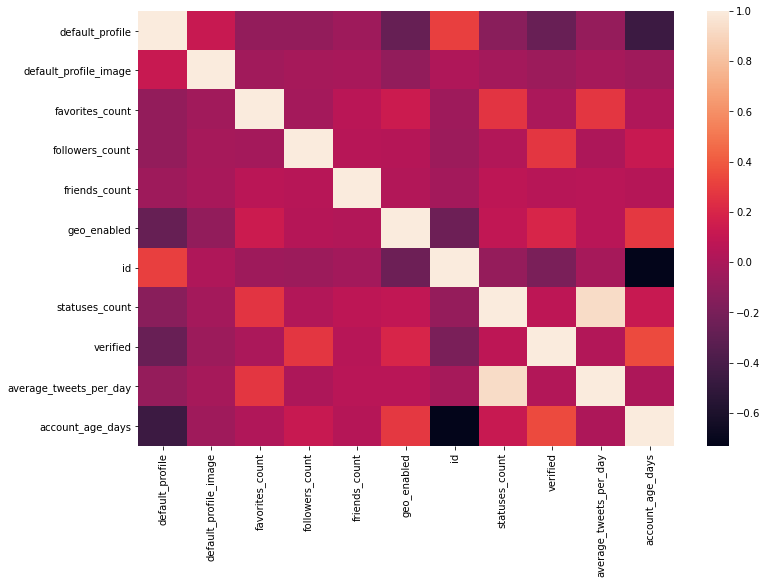

In [6]:
# Most of the them doesnot have any strong correlation
sns.heatmap(cor, 
        xticklabels=cor.columns,
        yticklabels=cor.columns)

In [7]:
## we can see here there are 48 unique values with actual values
print(data['lang'].nunique())
data['lang'].unique()

48


array(['en', 'ar', nan, 'so', 'it', 'es', 'fr', 'id', 'pt', 'ja', 'zh-cn',
       'de', 'lt', 'ru', 'tl', 'af', 'cy', 'tr', 'vi', 'ca', 'no', 'hu',
       'sw', 'ko', 'fa', 'el', 'sl', 'et', 'pl', 'fi', 'ro', 'nl', 'da',
       'sk', 'bg', 'sv', 'mk', 'hr', 'th', 'sq', 'cs', 'ur', 'hi', 'lv',
       'he', 'zh-tw', 'ne', 'uk', 'pa'], dtype=object)

In [8]:
# here we can see that most popular is english and spanish(es) - but english is the majority of the dataset
data['lang'].value_counts()

en       21450
es        1213
pt         704
it         637
ar         594
de         536
ja         378
fr         375
af         333
id         313
ru         250
tr         220
ca         198
tl         192
sw         182
da         174
no         172
nl         165
ro         148
cy         143
sv         126
so         125
ko         115
et          95
zh-cn       91
fi          72
pl          62
vi          55
hr          50
sl          43
hu          35
th          31
sk          31
lt          28
sq          23
bg          20
el          18
mk          16
uk          13
fa          12
cs          12
ur           9
hi           8
lv           6
zh-tw        3
he           2
ne           2
pa           1
Name: lang, dtype: int64

In [9]:
## so there are exactly 7957 nan values in the column of lang
## question is what to assign to it - maximum value = en or something else?
data[data['lang'].isnull()==True] 

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,id,lang,location,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
8,True,False,64,24,0,False,1.015022e+09,NaN,unknown,277,False,0.099,2802,human
19,True,False,510,6,33,False,3.845653e+08,NaN,unknown,639,False,0.197,3242,bot
40,False,False,722,1300,1137,True,2.356677e+08,NaN,unknown,70176,False,19.993,3510,human
42,False,False,2896,338,743,True,2.499019e+09,NaN,unknown,7167,False,3.135,2286,human
47,False,False,1325,25,851,False,5.190476e+07,NaN,unknown,1807,False,0.444,4069,bot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37412,False,False,1432,93,199,True,1.798306e+08,NaN,"Trabzon, Türkiye",1812,False,0.496,3654,human
37415,True,True,222,2,19,False,7.132937e+08,NaN,unknown,58,False,0.020,2948,bot
37420,False,False,2465,114,70,True,1.080032e+08,NaN,Salvador,5799,False,1.503,3859,bot
37422,True,False,1368,6,170,False,1.556873e+09,NaN,unknown,2056,False,0.789,2607,bot


In [10]:
data['location'].value_counts()

unknown                         13023
Los Angeles, CA                   524
New York, NY                      339
United States                     239
Washington, DC                    224
                                ...  
Kickapoo Tribal Land                1
Mia-Atl                             1
Ankara, Keçiören                    1
Lemgo (Deutschland)                 1
San Francisco, Bath & Sydney        1
Name: location, Length: 12047, dtype: int64

In [11]:
data[data['location'].isnull() ==True]

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,id,lang,location,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
4393,True,False,1312,34,95,False,106723717.0,NaN,NaN,2282,False,0.591,3863,human
19669,True,False,65,23,0,False,346429898.0,en,NaN,803,False,0.243,3306,bot
30520,False,False,86090,4077366,451,True,23019705.0,en,NaN,24337,True,5.817,4184,human


#### Dropping "Location" and "Language" as they have alot of null/missing values and they are not even holding solid information even after cleaning and encoding it.

In [12]:
data.drop(['location','lang'],axis=1,inplace=True)

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [14]:
data = data.apply(le.fit_transform)
data

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,id,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,0,0,4,1542,4,0,32155,8137,0,6372,750,0
1,0,0,535,860,880,0,32164,252,0,183,726,1
2,0,0,3204,172,594,1,32244,988,0,864,506,1
3,1,0,6264,517,633,1,32124,1303,0,889,835,1
4,0,0,88,9573,116,1,19851,4015,1,1339,2481,1
...,...,...,...,...,...,...,...,...,...,...,...,...
37433,1,0,650,139,1104,0,7386,340,0,84,3371,1
37434,0,0,6430,10461,605,1,24308,12389,1,6933,2125,1
37435,1,0,399,6555,190,0,24408,5432,1,2209,2116,1
37436,0,0,966,138,166,1,22987,970,0,339,2242,1


### Scaling the data using Standard Scaler

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
scaler.fit(data.drop('account_type',axis=1))

StandardScaler()

In [17]:
scaled_features = scaler.transform(data.drop('account_type',axis=1))
scaled_features

array([[-0.85077821, -0.12300468, -0.89436603, ..., -0.50264466,
         0.94048011, -1.60126097],
       [-0.85077821, -0.12300468, -0.77138319, ..., -0.50264466,
        -0.84709757, -1.62505306],
       [-0.85077821, -0.12300468, -0.15322651, ..., -0.50264466,
        -0.65040337, -1.8431472 ],
       ...,
       [ 1.17539447, -0.12300468, -0.80288162, ...,  1.98947702,
        -0.26192511, -0.24709463],
       [-0.85077821, -0.12300468, -0.67156096, ..., -0.50264466,
        -0.80203987, -0.12218616],
       [-0.85077821, -0.12300468, -0.6428418 , ..., -0.50264466,
        -0.75755983,  0.14844884]])

In [18]:
df_feat = pd.DataFrame(scaled_features,columns=data.columns[:-1])
df_feat.head()

,default_profile,default_profile_image,favorites_count,followers_count,friends_count,geo_enabled,id,statuses_count,verified,average_tweets_per_day,account_age_days
0,-0.850778,-0.123005,-0.894366,-0.261007,-0.667771,-0.915812,1.343053,0.346304,-0.502645,0.940480,-1.601261
1,-0.850778,-0.123005,-0.771383,-0.440713,0.116573,-0.915812,1.343929,-1.038999,-0.502645,-0.847098,-1.625053
2,-0.850778,-0.123005,-0.153227,-0.622000,-0.139502,1.091927,1.351715,-0.909693,-0.502645,-0.650403,-1.843147
3,1.175394,-0.123005,0.555488,-0.531093,-0.104583,1.091927,1.340036,-0.854351,-0.502645,-0.643183,-1.516997
4,-0.850778,-0.123005,-0.874911,1.855150,-0.567489,1.091927,0.145618,-0.377884,1.989477,-0.513208,0.114743


### Classifying using KNN Algorithm

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [20]:
##Keeping Shuffle = True

X = df_feat
y = data['account_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101 , shuffle = True)

In [21]:
%time
error_rate =[]
for i in range(1,25):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 4.77 µs


Text(0, 0.5, 'Error Rate')

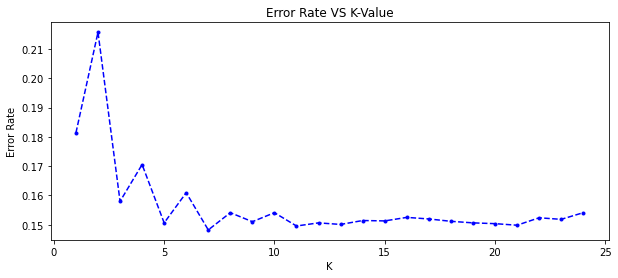

In [22]:
plt.figure(figsize=(10,4))
plt.plot(range(1,25),error_rate,color='blue',linestyle='--',marker='.')
plt.title("Error Rate VS K-Value")
plt.xlabel("K")
plt.ylabel('Error Rate')

#### We can see that for K = 11 or 15 - we get the minimum possible error.

In [23]:
knn = KNeighborsClassifier(n_neighbors=11)

In [24]:
knn.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=11)

In [25]:
pred = knn.predict(X_test)

In [26]:
print(confusion_matrix(y_test,pred))
print("-----------")
print(classification_report(y_test,pred))

[[1858  595]
 [ 525 4510]]
-----------
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2453
           1       0.88      0.90      0.89      5035

    accuracy                           0.85      7488
   macro avg       0.83      0.83      0.83      7488
weighted avg       0.85      0.85      0.85      7488



#### Using Cross Validation to train the model with different splits of the dataset

In [27]:
from sklearn.model_selection import KFold

#### Keeping the Shuffle = True

In [28]:
kf5 = KFold(n_splits=5, shuffle=True)

In [29]:
for train_index,test_index in kf5.split(X):
    print(train_index, test_index)

[    0     2     4 ... 37435 37436 37437] [    1     3     8 ... 37420 37427 37432]
[    1     2     3 ... 37432 37435 37437] [    0     5     6 ... 37433 37434 37436]
[    0     1     3 ... 37434 37436 37437] [    2    21    25 ... 37418 37425 37435]
[    0     1     2 ... 37434 37435 37436] [    4    13    20 ... 37430 37431 37437]
[    0     1     2 ... 37435 37436 37437] [    9    10    22 ... 37422 37426 37429]


In [30]:
%time
start = time.time()
knn = KNeighborsClassifier(n_neighbors=11)
i = 1
for train_index,test_index in kf5.split(X):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.loc[test_index]

    knn.fit(X_train, y_train) #Training the model
    print(f"Accuracy for the fold no. {i} on the validation set: \n {classification_report(y_test, knn.predict(X_test))}")
    print(confusion_matrix(y_test,knn.predict(X_test)))
    print("------------------------------------------------------------------- \n ")
    i += 1
    
end = time.time()
print("Tune Fit Time:", end - start)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Accuracy for the fold no. 1 on the validation set: 
               precision    recall  f1-score   support

           0       0.78      0.73      0.76      2487
           1       0.87      0.90      0.88      5001

    accuracy                           0.84      7488
   macro avg       0.83      0.82      0.82      7488
weighted avg       0.84      0.84      0.84      7488

[[1827  660]
 [ 515 4486]]
------------------------------------------------------------------- 
 
Accuracy for the fold no. 2 on the validation set: 
               precision    recall  f1-score   support

           0       0.79      0.75      0.77      2523
           1       0.88      0.90      0.89      4965

    accuracy                           0.85      7488
   macro avg       0.83      0.82      0.83      7488
weighted avg       0.85      0.85      0.85      7488

[[1892  631]
 [ 509 4456]]
---------------------------------------------------

In [31]:
from sklearn.model_selection import cross_val_score

In [32]:
cross_val_score(knn,X,y,cv=5,verbose=100,n_jobs=10)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    4.5s
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:    4.6s remaining:    6.9s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:    4.6s remaining:    3.1s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:    4.7s finished


array([0.84348291, 0.84495192, 0.84695513, 0.84506478, 0.8484039 ])

### Here , we can see that the average accuracy of KNN model is between 84% and 85% for K = 11 to 15 in almost 10 seconds

### Classfying using Support Vector Machines

In [33]:
from sklearn.svm import SVC

##### For SVM , Cross validation isnt enough - We also need to do hyperparameter tuning using GridSearchCV

In [34]:
from sklearn.model_selection import GridSearchCV

#### Using default RBF for classification as we have multiple features which means multiple dimensions and RBF is best suitable to work in infinite dimensions.

In [35]:
param_grid ={'C':[0.1,1,10],'gamma':[1,0.1,0.01]}

In [36]:
grid = GridSearchCV(SVC(),param_grid,verbose=100,cv=5,n_jobs=-1)

##### Fitting the SVM model with various parameters along with CV = 5

In [37]:
import time 
start = time.time()

grid.fit(X_train,y_train)

end = time.time()
print("Tune Fit Time:", end - start)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   43.8s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:   43.9s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:   44.9s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   46.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2

#### We can see here that it took almost 200 to 300 seconds to find the correct parameters and more time will be needed to predict the resulsts

In [38]:
# GridSearchCV will tell us which are the best parameters
grid.best_params_

{'C': 1, 'gamma': 1}

In [39]:
# Predicting Using Best Parameters
g_pred = grid.predict(X_test)

In [40]:
print(confusion_matrix(y_test,g_pred))
print(classification_report(y_test,g_pred))

[[1779  720]
 [ 566 4422]]
              precision    recall  f1-score   support

           0       0.76      0.71      0.73      2499
           1       0.86      0.89      0.87      4988

    accuracy                           0.83      7487
   macro avg       0.81      0.80      0.80      7487
weighted avg       0.83      0.83      0.83      7487



### SVM classifies with the accuracy of 80 to 83 percent which is just little to the accuracy of the KNN model.

### But , if we dig deeper and look at the values of Recall in the results of KNN - its almost 75 percent as compared to 70 percent of the BEST SVM model.

### Having higher Recall will help us to not wrongly classify bots as humans - which is very important in our case.

### Also, computational time is much lesser for the KNN(10 seconds) than in SVM (200+ seconds).

### Also, SVM is comparatively complex than KNN.

### As per my research and analysis ->  KNN ( with K = 11 or 15) is the best model.